In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import null_space

import dyflownet as dfn

def get_stationary_distribution(prob_matrix):
    A = prob_matrix - np.eye(prob_matrix.shape[0])
    nullspace = null_space(A.T)

    return (nullspace.T / np.sum(nullspace))[0, :]
    

## Freeway-Ramp Junction

source 0 -> sink 0

source 0 -> sink 1

source 1 -> sink 0


In [2]:
num_x_grid = 26

initial_condition = np.linspace(0, 5, num_x_grid)

state_len = len(initial_condition)

net_0 = dfn.net.Network(ID='net_0', state_len = state_len, num_step = 100000, time_step_size = 0.01)


source_0 = dfn.cell.Source(
    ID = 'source_0', initial_condition = {'density': [0]*state_len}, 
    boundary_inflow = dfn.flow.BoundaryInflow(boundary_inflow=0.9),
    sending = dfn.flow.PiecewiseLinearSendingFlow(free_flow_speed=1, capacity=1),
)


source_1 = dfn.cell.Source(
    ID = 'source_1', initial_condition = {'density': [0]*state_len}, 
    boundary_inflow = dfn.flow.BoundaryInflow(boundary_inflow=0.1),
    sending = dfn.flow.PiecewiseLinearSendingFlow(free_flow_speed=1, capacity=0.2),
)


sink_0 = dfn.cell.Sink(
    ID = 'sink_0', initial_condition = {'density': initial_condition}, 
    receiving = dfn.flow.PiecewiseLinearReceivingFlow(congestion_wave_speed=0.25, max_density=6, capacity=np.inf),
    boundary_outflow = dfn.flow.MarkovianPiecewiseLinearSendingFlow(
        mode_list = [0, 1],
        free_flow_speed = [1, 1],
        capacity = [1, 0.9], 
        prob_matrix = [[[0.9, 0.1], [0.1, 0.9]], [[0.5, 0.5], [0.1, 0.9]]],
        initial_condition = {'mode': 0},
        has_multi_regime = True, 
        regime_bound_list = [1],
    ),
)


sink_1 = dfn.cell.Sink(
    ID = 'sink_1', initial_condition = {'density': [0]*state_len}, 
    receiving = dfn.flow.UnboundedReceivingFlow(),
    boundary_outflow = dfn.flow.PiecewiseLinearSendingFlow(free_flow_speed=1, capacity=1),
)


junction_0 = dfn.node.FreewayRampJunction(
    ID = 'node_0', incoming_cell_list = [source_0, source_1], outgoing_cell_list = [sink_0, sink_1],
    split_ratio = [0.9, 0.1], onramp_priority = [1],
)


net_0.add_cell('source', source_0)
net_0.add_cell('source', source_1)
net_0.add_cell('sink', sink_0)
net_0.add_cell('sink', sink_1)

net_0.add_node(junction_0)

net_0.run()

source_0 initialized.
source_1 initialized.
sink_0 initialized.
sink_1 initialized.
node_0 initialized.
time cost: 89.6 seconds.


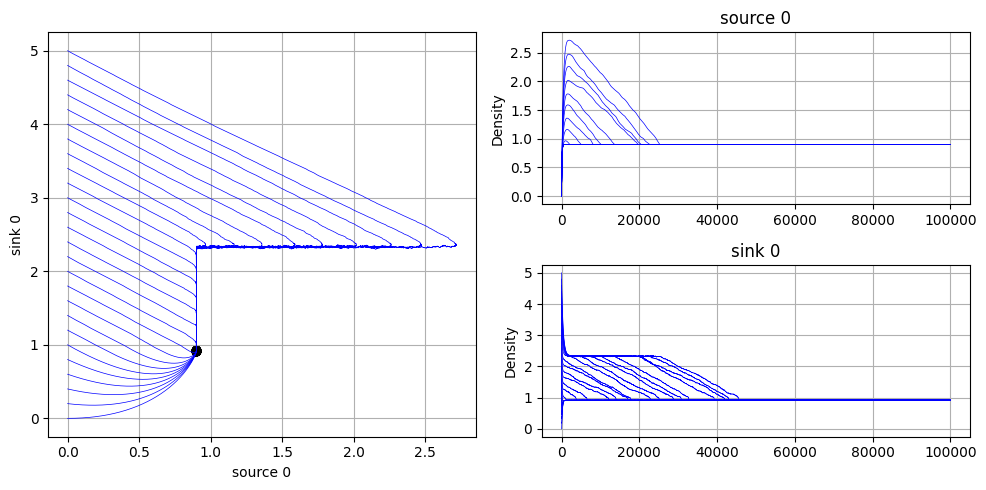

In [3]:
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)

plt.scatter(source_0.state_output['density'][:, -1], sink_0.state_output['density'][:, -1], color='k')
plt.plot(source_0.state_output['density'].T, sink_0.state_output['density'].T,  'b', linewidth=0.5)
plt.xlabel('source 0')
plt.ylabel('sink 0')
plt.grid()

plt.subplot(2, 2, 2)
plt.plot(source_0.state_output['density'].T, 'b', linewidth=0.5)
plt.title('source 0')
plt.ylabel('Density')
plt.grid()

plt.subplot(2, 2, 4)
plt.plot(sink_0.state_output['density'].T, 'b', linewidth=0.5)
plt.title('sink 0')
plt.ylabel('Density')
plt.grid()

plt.tight_layout()

plt.show()

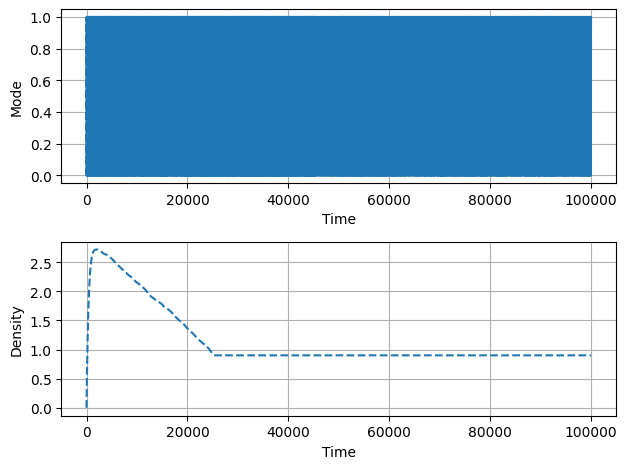

In [4]:
plt.subplot(2, 1, 1)
plt.plot(sink_0.flow_dict['boundary_outflow'].state_output['real_time_mode'][-1, :], '--')
plt.ylabel('Mode')
plt.xlabel('Time')
plt.grid()


plt.subplot(2, 1, 2)
plt.plot(source_0.state_output['density'][-1, :], '--')
plt.ylabel('Density')
plt.xlabel('Time')
plt.grid()

plt.tight_layout()

plt.show()

In [5]:
np.sum(sink_0.flow_dict['boundary_outflow'].co_state_output['real_time_regime'] != sink_0.flow_dict['boundary_outflow'].find_regime(sink_0.state_output['density'][:, :-1]))

0

In [6]:
print(sink_0.flow_dict['boundary_outflow'].find_regime(sink_0.state_output['density'][:, :-1]).shape)

print(sink_0.flow_dict['boundary_outflow'].state_output['real_time_mode'][:, 1:].shape)

(26, 100000)
(26, 100000)


In [7]:
print(get_stationary_distribution(np.array([[0.9, 0.1], [0.1, 0.9]])))

print(get_stationary_distribution(np.array([[0.5, 0.5], [0.1, 0.9]])))

[0.5 0.5]
[0.16666667 0.83333333]


In [8]:
np.average(sink_0.flow_dict['boundary_outflow'].state_output['real_time_mode'][:, 1:][sink_0.flow_dict['boundary_outflow'].find_regime(sink_0.state_output['density'][:, :-1])==0])

0.49995201023060776

In [9]:
np.average(sink_0.flow_dict['boundary_outflow'].state_output['real_time_mode'][:, 1:][sink_0.flow_dict['boundary_outflow'].find_regime(sink_0.state_output['density'][:, :-1])==1])

0.8330729009367688